## Analysis of the results of experiment 2 on LLaMA3.2: Image-to-Text Matching

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
folders = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
all_classifications = []
all_metrics = []

for folder in folders:
    ic = pd.read_csv(os.path.join(folder, 'image_classifications.csv'))
    cm = pd.read_csv(os.path.join(folder, 'classification_metrics.csv'))
    ic['run'] = folder
    cm['run'] = folder
    all_classifications.append(ic)
    all_metrics.append(cm)

df_classifications = pd.concat(all_classifications, ignore_index=True)
df_metrics = pd.concat(all_metrics, ignore_index=True)

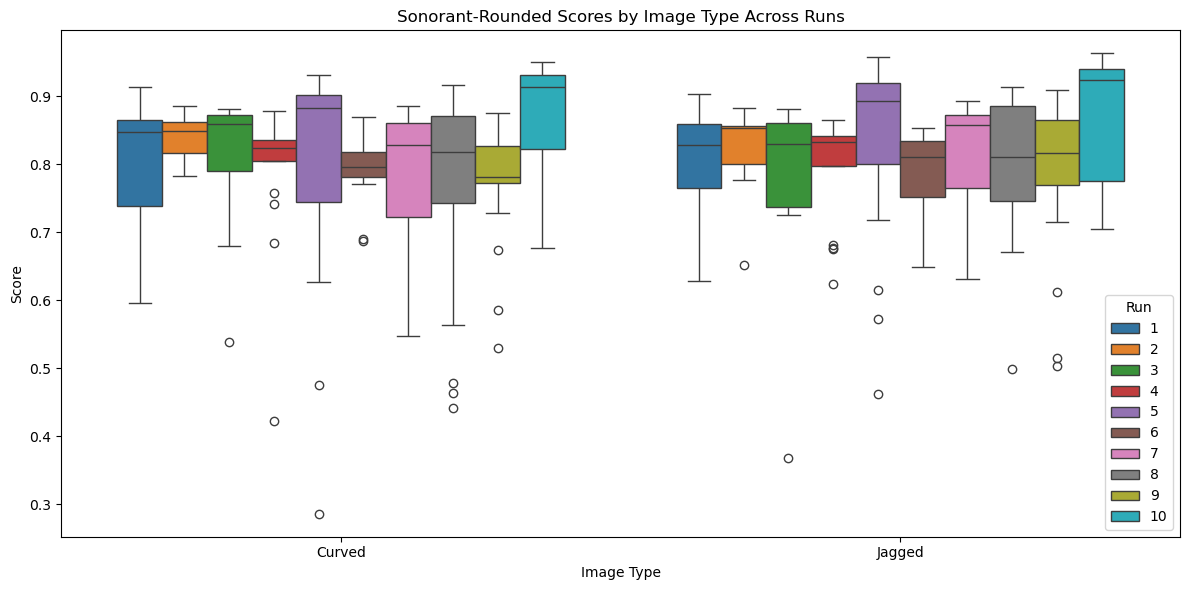

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_classifications, x='image_type', y='score_s_r', hue='run')
plt.title('Sonorant-Rounded Scores by Image Type Across Runs')
plt.ylabel('Score')
plt.xlabel('Image Type')
plt.legend(title='Run')
plt.tight_layout()
plt.show()

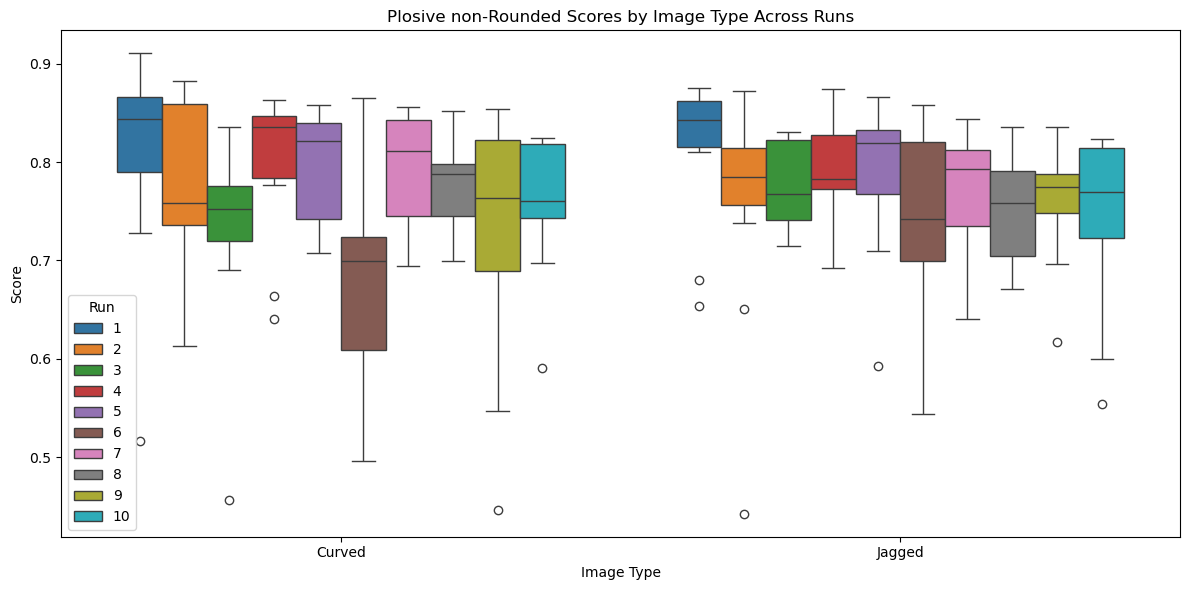

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_classifications, x='image_type', y='score_p_nr', hue='run')
plt.title('Plosive non-Rounded Scores by Image Type Across Runs')
plt.ylabel('Score')
plt.xlabel('Image Type')
plt.legend(title='Run')
plt.tight_layout()
plt.show()

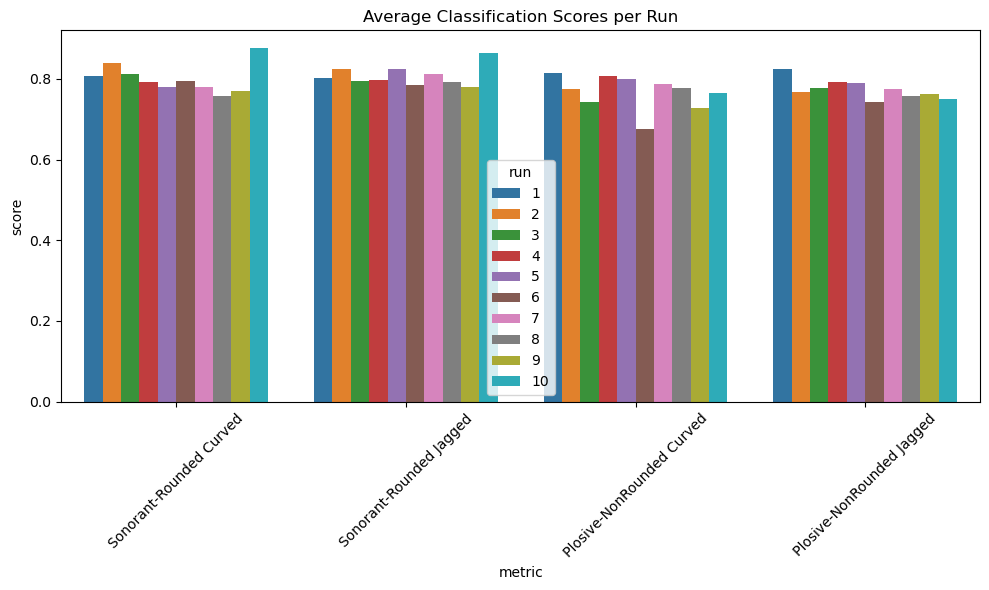

In [5]:
avg_scores = df_metrics.melt(id_vars='run', var_name='metric', value_name='score')

label_map = {
    'avg_score_s_r_curved': 'Sonorant-Rounded Curved',
    'avg_score_s_r_jagged': 'Sonorant-Rounded Jagged',
    'avg_score_p_nr_curved': 'Plosive-NonRounded Curved',
    'avg_score_p_nr_jagged': 'Plosive-NonRounded Jagged',
}

avg_scores['metric'] = avg_scores['metric'].replace(label_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_scores, x='metric', y='score', hue='run')
plt.xticks(rotation=45)
plt.title('Average Classification Scores per Run')
plt.tight_layout()
plt.show()

C:\Users\robkr\AppData\Local\Temp\ipykernel_4312\1984590304.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_melted, x='Condition', y='Score', errorbar='sd', capsize=0.1, palette='pastel')


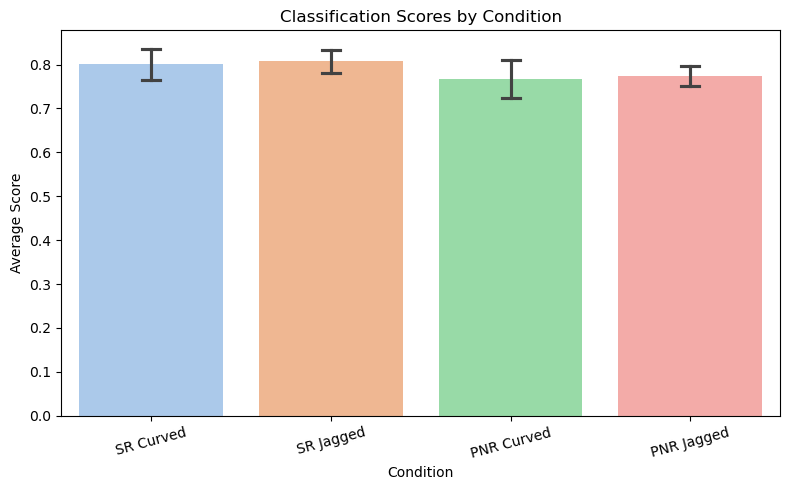

In [6]:
label_map = {
    'avg_score_s_r_curved': 'SR Curved',
    'avg_score_s_r_jagged': 'SR Jagged',
    'avg_score_p_nr_curved': 'PNR Curved',
    'avg_score_p_nr_jagged': 'PNR Jagged',
}

df_renamed = df_metrics.rename(columns=label_map)

df_melted = df_renamed.melt(id_vars='run', var_name='Condition', value_name='Score')

plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Condition', y='Score', errorbar='sd', capsize=0.1, palette='pastel')

plt.title('Classification Scores by Condition')
plt.ylabel('Average Score')
plt.xlabel('Condition')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

C:\Users\robkr\AppData\Local\Temp\ipykernel_4312\1257761979.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


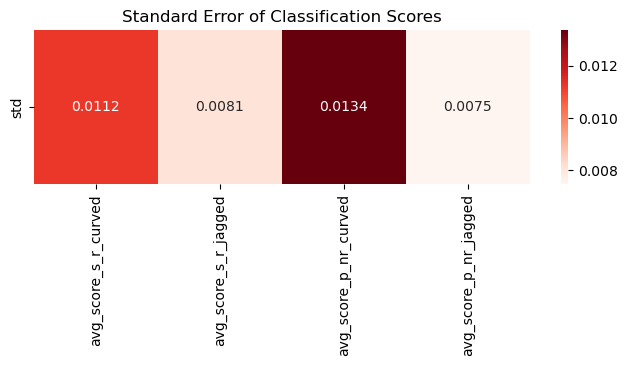

In [7]:
sd_scores = df_metrics.drop(columns='run').std().to_frame(name='std').T
se_scores = sd_scores / np.sqrt(len(df_metrics))  # SE = SD / sqrt(N)

plt.figure(figsize=(8, 2))
sns.heatmap(se_scores, annot=True, cmap='Reds', fmt=".4f")
plt.title('Standard Error of Classification Scores')
plt.tight_layout()
plt.show()

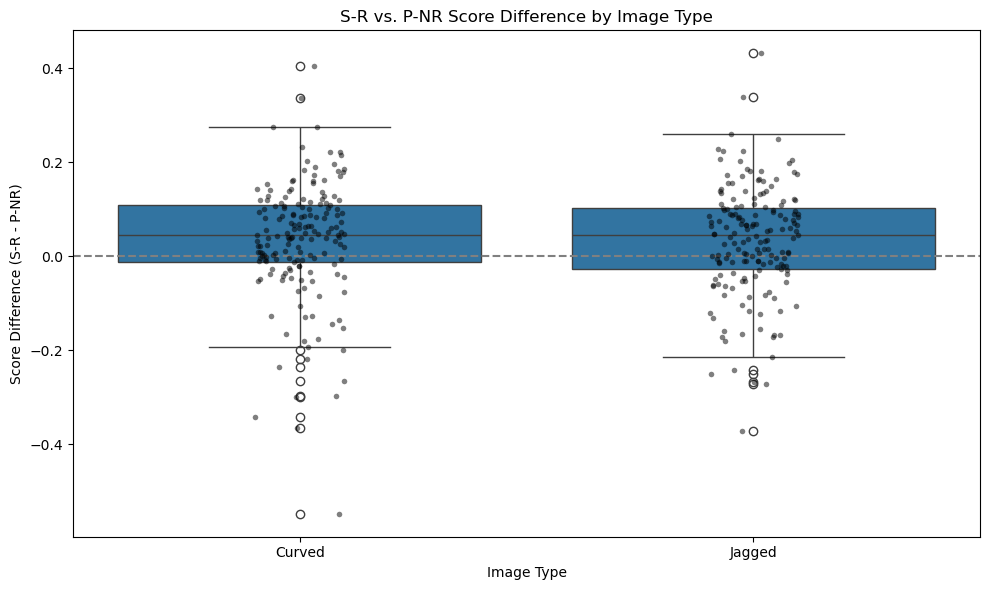

In [8]:
folders = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
all_data = []

for folder in folders:
    df = pd.read_csv(os.path.join(folder, 'image_classifications.csv'))
    df['run'] = folder
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

# Calculate score difference per image
df_all['score_diff'] = df_all['score_s_r'] - df_all['score_p_nr']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='image_type', y='score_diff')
sns.stripplot(data=df_all, x='image_type', y='score_diff', color='black', size=4, alpha=0.5)

plt.axhline(0, linestyle='--', color='gray')
plt.title('S-R vs. P-NR Score Difference by Image Type')
plt.ylabel('Score Difference (S-R - P-NR)')
plt.xlabel('Image Type')
plt.tight_layout()
plt.show()

In [9]:
from scipy import stats

# Test 1: S-R scores - curved vs jagged
sr_curved = df_classifications[df_classifications['image_type'] == 'Curved']['score_s_r']
sr_jagged = df_classifications[df_classifications['image_type'] == 'Jagged']['score_s_r']

# Test 2: P-NR scores - jagged vs curved
pnr_curved = df_classifications[df_classifications['image_type'] == 'Curved']['score_p_nr'] 
pnr_jagged = df_classifications[df_classifications['image_type'] == 'Jagged']['score_p_nr']

print(len(sr_curved), len(sr_jagged), len(pnr_curved), len(pnr_jagged))

# Test normality
_, p_sr_curved = stats.shapiro(sr_curved)
_, p_sr_jagged = stats.shapiro(sr_jagged)
_, p_pnr_curved = stats.shapiro(pnr_curved)
_, p_pnr_jagged = stats.shapiro(pnr_jagged)

# Test variance equality
_, p_var_sr = stats.levene(sr_curved, sr_jagged)
_, p_var_pnr = stats.levene(pnr_curved, pnr_jagged)

# Perform t-tests
def run_ttest(data1, data2, equal_var):
    t, p = stats.ttest_ind(data1, data2, equal_var=equal_var)
    mean1, mean2 = data1.mean(), data2.mean()
    return t, p, mean1, mean2

# S-R test
equal_var_sr = p_var_sr > 0.05
t_sr, p_sr, mean_sr_curved, mean_sr_jagged = run_ttest(sr_curved, sr_jagged, equal_var_sr)

# P-NR test  
equal_var_pnr = p_var_pnr > 0.05
t_pnr, p_pnr, mean_pnr_curved, mean_pnr_jagged = run_ttest(pnr_curved, pnr_jagged, equal_var_pnr)

# Print results
print("S-R Words Test (Curved vs Jagged):")
print(f"Shapiro test p-values: Curved={p_sr_curved:.4f}, Jagged={p_sr_jagged:.4f}")
print(f"Levene test p-value: {p_var_sr:.4f}")
print(f"{'Welch' if not equal_var_sr else 'Student'}'s t-test: t={t_sr:.4f}, p={p_sr:.4f}")
print(f"Means: Curved={mean_sr_curved:.4f}, Jagged={mean_sr_jagged:.4f}")

print("\nP-NR Words Test (Jagged vs Curved):")
print(f"Shapiro test p-values: Curved={p_pnr_curved:.4f}, Jagged={p_pnr_jagged:.4f}")
print(f"Levene test p-value: {p_var_pnr:.4f}")
print(f"{'Welch' if not equal_var_pnr else 'Student'}'s t-test: t={t_pnr:.4f}, p={p_pnr:.4f}")
print(f"Means: Curved={mean_pnr_curved:.4f}, Jagged={mean_pnr_jagged:.4f}")

# Check if both conditions are met
sr_condition = (p_sr < 0.05) and (mean_sr_curved > mean_sr_jagged)
pnr_condition = (p_pnr < 0.05) and (mean_pnr_jagged > mean_pnr_curved)

if sr_condition and pnr_condition:
    print("\nBoth conditions are met!")
else:
    print("\nBoth conditions are NOT met.")

170 170 170 170
S-R Words Test (Curved vs Jagged):
Shapiro test p-values: Curved=0.0000, Jagged=0.0000
Levene test p-value: 0.8897
Student's t-test: t=-0.5586, p=0.5768
Means: Curved=0.8007, Jagged=0.8071

P-NR Words Test (Jagged vs Curved):
Shapiro test p-values: Curved=0.0000, Jagged=0.0000
Levene test p-value: 0.0270
Welch's t-test: t=-0.7829, p=0.4342
Means: Curved=0.7671, Jagged=0.7737

Both conditions are NOT met.


In [10]:
from scipy.stats import ttest_ind, shapiro, levene

# Prepare data for S-R: curved vs jagged
sr_curved = df_classifications[df_classifications['image_type'] == 'Curved']['score_s_r']
sr_jagged = df_classifications[df_classifications['image_type'] == 'Jagged']['score_s_r']

# Prepare data for P-NR: jagged vs curved
pnr_jagged = df_classifications[df_classifications['image_type'] == 'Jagged']['score_p_nr']
pnr_curved = df_classifications[df_classifications['image_type'] == 'Curved']['score_p_nr']

def normality_and_variance_test(group1, group2):
    # Normality
    stat1, p1 = shapiro(group1)
    stat2, p2 = shapiro(group2)
    normal = (p1 > 0.05) and (p2 > 0.05)
    # Variance
    stat_var, p_var = levene(group1, group2)
    equal_var = p_var > 0.05
    return normal, equal_var

# S-R: curved vs jagged
normal_sr, equal_var_sr = normality_and_variance_test(sr_curved, sr_jagged)
ttest_sr = ttest_ind(sr_curved, sr_jagged, equal_var=equal_var_sr)

# P-NR: jagged vs curved
normal_pnr, equal_var_pnr = normality_and_variance_test(pnr_jagged, pnr_curved)
ttest_pnr = ttest_ind(pnr_jagged, pnr_curved, equal_var=equal_var_pnr)

print("S-R (Curved vs Jagged):")
print(f"Normality: {normal_sr}, Equal Variance: {equal_var_sr}")
print(f"T-test: statistic={ttest_sr.statistic:.4f}, p-value={ttest_sr.pvalue:.4g}")
print(f"Mean Curved: {sr_curved.mean():.4f}, Mean Jagged: {sr_jagged.mean():.4f}")

print("\nP-NR (Jagged vs Curved):")
print(f"Normality: {normal_pnr}, Equal Variance: {equal_var_pnr}")
print(f"T-test: statistic={ttest_pnr.statistic:.4f}, p-value={ttest_pnr.pvalue:.4g}")
print(f"Mean Jagged: {pnr_jagged.mean():.4f}, Mean Curved: {pnr_curved.mean():.4f}")

# Check if both conditions are met
sr_condition = (ttest_sr.pvalue < 0.05) and (sr_curved.mean() > sr_jagged.mean())
pnr_condition = (ttest_pnr.pvalue < 0.05) and (pnr_jagged.mean() > pnr_curved.mean())

if sr_condition and pnr_condition:
    print("\nBoth conditions are met: S-R scores are higher for curved, and P-NR scores are higher for jagged images.")
else:
    print("\nBoth conditions are NOT met. The pattern may reflect an overall preference rather than a double dissociation.")

S-R (Curved vs Jagged):
Normality: False, Equal Variance: True
T-test: statistic=-0.5586, p-value=0.5768
Mean Curved: 0.8007, Mean Jagged: 0.8071

P-NR (Jagged vs Curved):
Normality: False, Equal Variance: False
T-test: statistic=0.7829, p-value=0.4342
Mean Jagged: 0.7737, Mean Curved: 0.7671

Both conditions are NOT met. The pattern may reflect an overall preference rather than a double dissociation.
